In [1]:
# general packages
import matplotlib.pyplot as plt
import numpy as np
import os

# packages from Allen Institute:
from meshparty import meshwork # version 1.16.4

https://github.com/AllenInstitute/swdb_2022/blob/main/DynamicBrain/EM_reference_Materials/EM_Meshwork_Creation.ipynb

In [7]:
# our handpicked cells:
cells = {'Basket': [os.path.join('..', 'data', fn) for fn in os.listdir('../data') if 'Basket' in fn],
         'Martinotti': [os.path.join('..', 'data', fn) for fn in os.listdir('../data') if 'Martinotti' in fn]}

In [2]:
# from the Allen database
cells = {'Basket': [os.path.join('..', 'data', fn) for fn in os.listdir('../data') if 'BC' in fn],
         'Martinotti': [os.path.join('..', 'data', fn) for fn in os.listdir('../data') if 'MC' in fn]}

In [3]:
def load_cell(nrn_h5_file):
    """
    we translate everything in terms of skeleton indices ! (mesh properties)
    """
    nrn = meshwork.load_meshwork(nrn_h5_file)
    
    nrn.pre_syn_sites = nrn.skeleton.mesh_to_skel_map[nrn.anno.pre_syn.df['pre_pt_mesh_ind']]
    
    nrn.post_syn_sites = nrn.skeleton.mesh_to_skel_map[nrn.anno.post_syn.df['post_pt_mesh_ind']]
    
    axon_inds, Q = meshwork.algorithms.split_axon_by_annotation(nrn, 
                                                                pre_anno='pre_syn',
                                                                post_anno='post_syn')
    
    if Q>0.5:
        nrn.axon_inds = nrn.skeleton.mesh_to_skel_map[axon_inds]
        nrn.is_axon = np.array([(m in nrn.axon_inds) for m in nrn.skeleton_indices], dtype=bool)
        # dendritic cover paths
        nrn.dend_cover_paths = []
        for cover_path in nrn.skeleton.cover_paths:
            path = [c for c in cover_path if c not in nrn.axon_inds]
            if len(path)>0:
                nrn.dend_cover_paths.append(path)
    else:
        print('axon splitting not trusted...')

    return nrn

In [4]:
# example
nrn = load_cell(cells['Basket'][1])

In [5]:
def build_fig(key,
              cmap=plt.cm.magma,
              with_pre = False,
              with_post = False,
              Ncol = 5):
    
    Nrow = int(len(cells[key]['nrn'])/Ncol+0.99)

    fig, AX = plt.subplots(Nrow, 1, 
                           figsize=(12, 2*Nrow), frameon=False)
    
    fig.subplots_adjust(wspace=0.05, hspace=0.1)
    fig.suptitle(key+ ' cells', fontsize=10)

    for i in range(len(cells[key]['nrn'])):

        plot_cell(cells[key]['nrn'][i], AX[int(i/Ncol)],
                  shift=i*5e2,
                  with_pre = with_pre,
                  with_post = with_post,
                  color=cmap(0.25+i/len(cells[key]['nrn'])/2.))
        
    for ax in AX:
        ax.invert_yaxis()
        ax.axis('equal')
        ax.plot(ax.get_xlim()[0]*np.ones(2), ax.get_ylim()[1]+200*np.arange(2), 'k-', lw=1)
        ax.annotate('200$\mu$m ', (ax.get_xlim()[0], ax.get_ylim()[1]), rotation=90, ha='right', va='top')
        ax.axis('off')
        
    return fig, AX

def plot_cell(nrn, 
              ax=None, 
              shift=0,
              proj_axis1=0, proj_axis2=1, 
              with_pre = False,
              with_post = False,
              with_segID=True,
              color='k',
              clean=True, lw=0.2):
    
    if ax is None:
        ax = plt.gca()

    if with_pre:
        ax.scatter(shift+\
                   nrn.anno.pre_syn.points[:,proj_axis1]/1e3,
                   nrn.anno.pre_syn.points[:,proj_axis2]/1e3,
                   color='tomato', s=8, alpha=.5, label='pre syn.')

    if with_post:
        ax.scatter(shift+\
                   nrn.anno.post_syn.points[:,proj_axis1]/1e3,
                   nrn.anno.post_syn.points[:,proj_axis2]/1e3,
                   color='turquoise', s=8, alpha=.5, label='post syn.')
    
    # plotting using the "cover_paths"
    for cover_path in nrn.skeleton.cover_paths:
        # dendrites
        path_verts = nrn.skeleton.vertices[cover_path,:]
        ax.plot(shift+\
                path_verts[:,proj_axis1]/1e3, 
                path_verts[:,proj_axis2]/1e3,
                color=color, lw=lw)
    if hasattr(nrn, 'dend_cover_paths'):
        ax.annotate('\n dendrites ', (1,1), xycoords='axes fraction', color='orange', va='top', ha='right')
        for cover_path in nrn.dend_cover_paths:
            # dendrites
            path_verts = nrn.skeleton.vertices[cover_path,:]
            ax.plot(shift+\
                    path_verts[:,proj_axis1]/1e3, 
                    path_verts[:,proj_axis2]/1e3,
                    color='orange', lw=2*lw)

    if with_segID:
        ax.annotate('\n%s' % nrn.seg_id,
                    (shift+nrn.anno.post_syn.points[:,proj_axis1].min()/1e3,
                     nrn.anno.post_syn.points[:,proj_axis2].min()/1e3), 
                    xycoords='data', fontsize=5)


    # plot soma
    ax.scatter(shift+\
                   nrn.skeleton.vertices[:, proj_axis1][nrn.skeleton.root]/1e3,
               nrn.skeleton.vertices[:, proj_axis2][nrn.skeleton.root]/1e3,
               s=40,color='violet', label='put. soma')

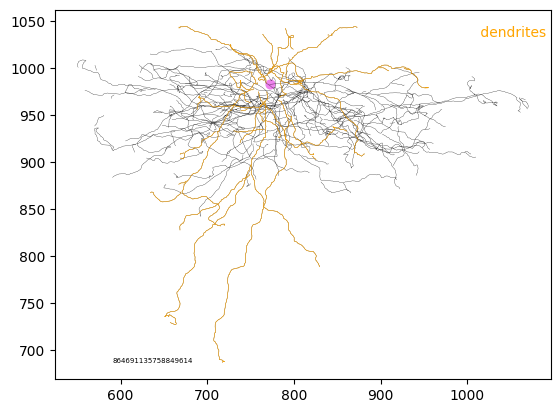

In [6]:
nrn = load_cell(cells['Basket'][4])
plot_cell(nrn)

Text(0, 0.5, 'linear density (syn./$\\mu$m)')

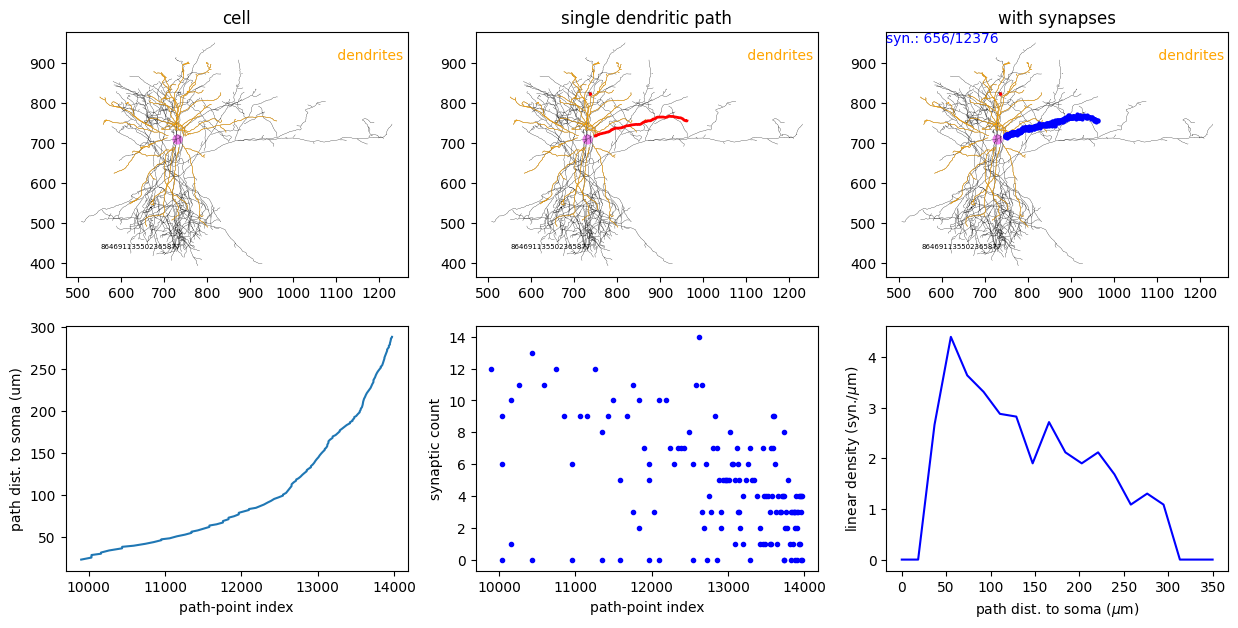

In [7]:
nrn = load_cell(cells['Basket'][1])

path = nrn.dend_cover_paths[1]

fig, AX = plt.subplots(2, 3, figsize=(15,7))

bins = np.linspace(0, 350, 20)

for ax, title in zip(AX[0][:3], ['cell', 'single dendritic path', 'with synapses']):
    plot_cell(nrn, ax=ax)
    ax.set_title(title)

for ax in AX[0][1:3]:
    ax.plot(nrn.skeleton.vertices[path,0]/1e3, 
            nrn.skeleton.vertices[path,1]/1e3, color='r', lw=2)
    ax.plot(nrn.vertices[path,0]/1e3+nrn.skeleton.vertices[nrn.root,0]/1e3, 
            nrn.vertices[path,1]/1e3+nrn.skeleton.vertices[nrn.root,1]/1e3, color='r', lw=2)

synapses_pt_in_path = np.array([d for d in nrn.post_syn_sites if (d in path)])

if len(synapses_pt_in_path)>0:
    # adding a random jitter so that densely innervated areas look bigger
    AX[0][2].plot(nrn.skeleton.vertices[synapses_pt_in_path,0]/1e3+2*np.random.randn(len(synapses_pt_in_path)), 
                  nrn.skeleton.vertices[synapses_pt_in_path,1]/1e3+2*np.random.randn(len(synapses_pt_in_path)),
                  'b.', ms=4)

path_to_soma = [nrn.skeleton.distance_to_root[p]/1_000 for p in path]

AX[1][0].plot(path, path_to_soma)
AX[1][0].set_xlabel('path-point index'); AX[1][0].set_ylabel('path dist. to soma (um)')

count_along_path = np.zeros(len(path))
for i, p in enumerate(path):
    count_along_path[i] = np.sum(nrn.post_syn_sites==p)

AX[0][2].annotate('syn.: %i/%i' % (count_along_path.sum(), len(nrn.post_syn_sites)),
                  (0,1), xycoords='axes fraction', va='top', color='b')

AX[1][1].plot(path, count_along_path, 'b.')
AX[1][1].set_xlabel('path-point index'); AX[1][1].set_ylabel('synaptic count')

binned_dist = np.digitize(path_to_soma, bins=bins)
density_hist = np.zeros(len(bins))

for b in range(len(bins)):
    # we sum all synapses that fall into this bin and we divide by the bin length
    density_hist[b] = np.sum(count_along_path[binned_dist==b])/(bins[1]-bins[0])

AX[1][2].plot(bins, density_hist, 'b-')
AX[1][2].set_xlabel('path dist. to soma ($\mu$m)'); AX[1][2].set_ylabel('linear density (syn./$\mu$m)')

In [4]:
def compute_single_cell(nrn_h5_file, 
                        bins = np.linspace(0, 400, 50),
                        with_fig=False):
    
    nrn = load_cell(nrn_h5_file)
    
    if with_fig:
        fig, AX = plt.subplots(1, 2, figsize=(12,4))

    DENSITY_HIST, Ntot_syn = [], 0

    for i, path in enumerate(nrn.dend_cover_paths):
        
        # we plot all paths with a different color
        if with_fig:
            AX[0].plot(nrn.skeleton.vertices[path,0]/1e3, 
                       nrn.skeleton.vertices[path,1]/1e3)
    
        path_to_soma = [nrn.skeleton.distance_to_root[p]/1_000 for p in path]

        count_along_path = np.zeros(len(path))
        for i, p in enumerate(path):
            count_along_path[i] = np.sum(nrn.post_syn_sites==p)

        binned_dist = np.digitize(path_to_soma, bins=bins)
        density_hist = np.ones(len(bins))*np.nan # nan by default
        for b in range(len(bins)):
            if np.sum(binned_dist==b)>0:
                # we sum all synapses that fall into this bin and we divide by the bin length
                density_hist[b] = np.sum(count_along_path[binned_dist==b])/(bins[1]-bins[0])

        DENSITY_HIST.append(density_hist)
        Ntot_syn += count_along_path.sum()
    
    print('synapses counted: %i/%i' % (Ntot_syn, len(nrn.anno.post_syn.df['post_pt_mesh_ind'])))

    if with_fig:
        AX[1].plot(bins, np.nanmean(DENSITY_HIST, axis=0)) # only non-infinite values contributing

        AX[0].set_title('looping over dendritic paths')
        AX[0].axis('equal')
        
        AX[1].set_xlabel('path dist. to soma ($\mu$m)'); 
        AX[1].set_ylabel('linear density (syn./$\mu$m)')
    else:
        fig = None
        
    return bins, np.nanmean(DENSITY_HIST, axis=0), fig



 - Basket [...]
      32 synapses not added (0.22%)
      21 synapses not added (0.36%)
      34 synapses not added (0.35%)
      17 synapses not added (0.23%)
      22 synapses not added (0.26%)
      51 synapses not added (0.39%)
      38 synapses not added (0.29%)
      11 synapses not added (0.14%)
      17 synapses not added (0.24%)
      46 synapses not added (0.39%)
      32 synapses not added (0.22%)
      32 synapses not added (0.34%)
      34 synapses not added (0.28%)
      23 synapses not added (0.28%)
      22 synapses not added (0.24%)
      44 synapses not added (0.34%)
      33 synapses not added (0.24%)
      22 synapses not added (0.31%)
      34 synapses not added (0.35%)
      39 synapses not added (0.46%)
      42 synapses not added (0.37%)
      17 synapses not added (0.24%)
      53 synapses not added (0.60%)
      51 synapses not added (0.39%)
 - Martinotti [...]
      19 synapses not added (0.38%)
      19 synapses not added (0.82%)
      7 synapses not added (

## Example Basket cell

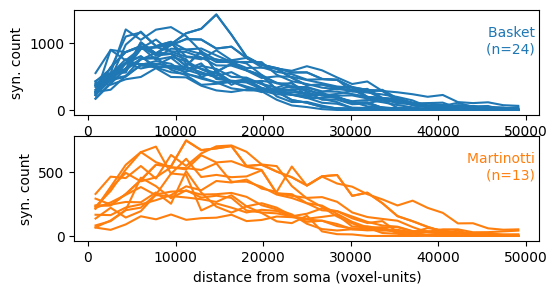

In [6]:
_ = compute_single_cell(cells['Basket'][0], with_fig=True)
plt.ylim([0,5])

## Example Martinotti cell

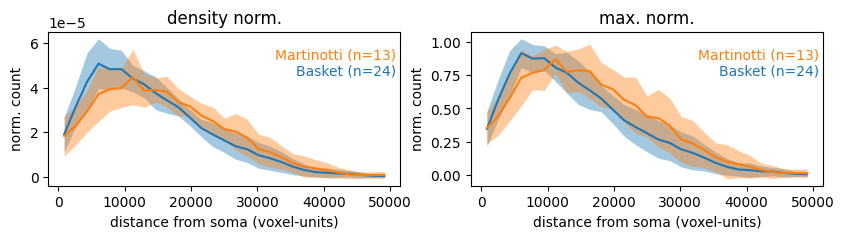

In [7]:
_ = compute_single_cell(cells['Martinotti'][0], with_fig=True)
plt.ylim([0,5])

In [24]:
bins = np.linspace(10, 350, 20)

Martinotti_Density = []
for cell in cells['Martinotti']:
    try:
        _, density, _ = compute_single_cell(cell,
                                            bins = bins)
        Martinotti_Density.append(density)
    except BaseException as be:
        print(be)

Basket_Density = []
for cell in cells['Basket']:
    try:
        _, density, _ = compute_single_cell(cell,
                                            bins = bins)
        Basket_Density.append(density)
    except BaseException as be:
        print(be)

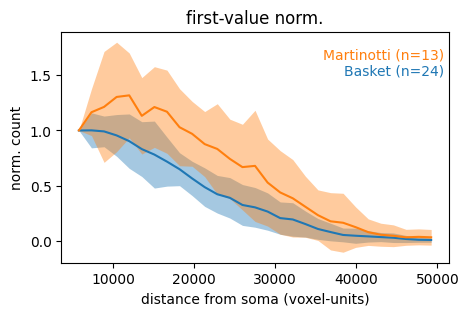

In [31]:
fig, AX = plt.subplots(1, 2, figsize=(10,3))

for ax, density, c, title in zip(AX, [Basket_Density, Martinotti_Density],
                                 ['red', 'blue'], ['Basket', 'Martinotti']):
    
    for d in density:
        ax.plot(bins[1:], d[1:], lw=0.1)
        
    x, y, sy = bins[1:], np.nanmean(density, axis=0)[1:], np.nanstd(density, axis=0)[1:]
    ax.plot(x, y, color=c)
    ax.fill_between(x, y-sy, y+sy, color=c, alpha=0.2, lw=0)
    
    ax.set_title('%s cell' % title, color=c); 
    ax.set_xlabel('path dist. to soma ($\mu$m)')
    ax.set_ylabel('linear density (syn./$\mu$m)')
    ax.set_ylim([0,4])

In [ ]:
fig, AX = build_fig('Basket')
fig.suptitle('Basket cells', fontsize=10)
fig.savefig('/home/yann.zerlaut/Desktop/figs/basket.png', dpi=300)

In [ ]:
fig, AX = build_fig('Basket', with_post=True)
fig.suptitle('Basket cells: "post" sites', fontsize=10)
fig.savefig('/home/yann.zerlaut/Desktop/figs/basket-post.png', dpi=300)

In [ ]:
fig, AX = build_fig('Basket', with_pre=True)
fig.suptitle('Basket cells: "pre" sites', fontsize=10)
fig.savefig('/home/yann.zerlaut/Desktop/figs/basket-pre.png', dpi=300)

In [ ]:
fig, AX = build_fig('Martinotti')
fig.suptitle('Martinotti cells', fontsize=10)
fig.savefig('/home/yann.zerlaut/Desktop/figs/martinotti.png', dpi=300)

In [ ]:
fig, AX = build_fig('Martinotti', with_pre=True)
fig.suptitle('Martinotti cells', fontsize=10)
fig.suptitle('Martinotti cells: "pre" sites', fontsize=10)
fig.savefig('/home/yann.zerlaut/Desktop/figs/martinotti-pre.png', dpi=300)

In [ ]:
fig, AX = build_fig('Martinotti', with_post=True)
fig.suptitle('Martinotti cells: "post" sites', fontsize=10)
fig.savefig('/home/yann.zerlaut/Desktop/figs/martinotti-post.png', dpi=300)